#  Library

In [2]:
# %%capture load_library
# !pip install sweetviz
# !pip install dtale

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from scipy.stats import skew
from statsmodels.stats.outliers_influence  import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


# Import Dataset

In [4]:
dir_csv = "/kaggle/input/car-sales/Car_sales.csv"
load_dataset = pd.read_csv(dir_csv)
load_dataset.head()

,Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,NaN
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639


In [5]:
# import sweetviz as sv
# analyze_report = sv.analyze(load_dataset)
# analyze_report.show_html('report.html', open_browser=True)

In [234]:
def standardize_column_names(df):
    # Convert column names to lowercase
    df.columns = df.columns.str.lower()
    
    # Remove leading/trailing whitespaces
    df.columns = df.columns.str.strip()
    
    # Replace spaces with underscores
    df.columns = df.columns.str.replace(' ', '_')
    
    # Remove special characters
    df.columns = df.columns.str.replace('[^\w\s]', '',regex=True)
       
    # Replace multiple consecutive underscores with a single underscore
    df.columns = df.columns.str.replace('_+', '_',regex=True)
    
    # Remove "_name" from column names if they start with an underscore
    df.columns = df.columns.str.replace('^_', '',regex=True)
    
    return df

dataset = standardize_column_names(load_dataset)

In [7]:
print(dataset.shape)
#change the position of column
idx = dataset.columns.get_loc('price_in_thousands')
column = dataset.pop('price_in_thousands')
dataset.insert(len(dataset.columns),'price_in_thousands',column)


(157, 16)


In [8]:
dataset.head()

,manufacturer,model,sales_in_thousands,year_resale_value,vehicle_type,engine_size,horsepower,wheelbase,width,length,curb_weight,fuel_capacity,fuel_efficiency,latest_launch,power_perf_factor,price_in_thousands
0,Acura,Integra,16.919,16.360,Passenger,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150,21.50
1,Acura,TL,39.384,19.875,Passenger,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778,28.40
2,Acura,CL,14.114,18.225,Passenger,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,NaN,NaN
3,Acura,RL,8.588,29.725,Passenger,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779,42.00
4,Audi,A4,20.397,22.255,Passenger,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639,23.99


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   manufacturer        157 non-null    object 
 1   model               157 non-null    object 
 2   sales_in_thousands  157 non-null    float64
 3   year_resale_value   121 non-null    float64
 4   vehicle_type        157 non-null    object 
 5   engine_size         156 non-null    float64
 6   horsepower          156 non-null    float64
 7   wheelbase           156 non-null    float64
 8   width               156 non-null    float64
 9   length              156 non-null    float64
 10  curb_weight         155 non-null    float64
 11  fuel_capacity       156 non-null    float64
 12  fuel_efficiency     154 non-null    float64
 13  latest_launch       157 non-null    object 
 14  power_perf_factor   155 non-null    float64
 15  price_in_thousands  155 non-null    float64
dtypes: float

**Continuous variable:** sales_in_thousands,price_in_thousands,year_resale_value,engine_size,horsepower,wheelbase,width,length,curb_weight,fuel_capacity,fuel_efficency,power_perf_factor(12)

**Categorical variable:**                                                                                            manufacturer,model,vehicle_type

**Datetime**
latest_lunch

In [10]:
dataset.describe()

,sales_in_thousands,year_resale_value,engine_size,horsepower,wheelbase,width,length,curb_weight,fuel_capacity,fuel_efficiency,power_perf_factor,price_in_thousands
count,157.000000,121.000000,156.000000,156.000000,156.000000,156.000000,156.000000,155.000000,156.000000,154.000000,155.000000,155.000000
mean,52.998076,18.072975,3.060897,185.948718,107.487179,71.150000,187.343590,3.378026,17.951923,23.844156,77.043591,27.390755
std,68.029422,11.453384,1.044653,56.700321,7.641303,3.451872,13.431754,0.630502,3.887921,4.282706,25.142664,14.351653
min,0.110000,5.160000,1.000000,55.000000,92.600000,62.600000,149.400000,1.895000,10.300000,15.000000,23.276272,9.235000
25%,14.114000,11.260000,2.300000,149.500000,103.000000,68.400000,177.575000,2.971000,15.800000,21.000000,60.407707,18.017500
50%,29.450000,14.180000,3.000000,177.500000,107.000000,70.550000,187.900000,3.342000,17.200000,24.000000,72.030917,22.799000
75%,67.956000,19.875000,3.575000,215.000000,112.200000,73.425000,196.125000,3.799500,19.575000,26.000000,89.414878,31.947500
max,540.561000,67.550000,8.000000,450.000000,138.700000,79.900000,224.500000,5.572000,32.000000,45.000000,188.144323,85.500000


## Data Preprocessing

**Check Duplicates**

In [11]:
duplicates = dataset.duplicated()
print(duplicates.value_counts())

False    157
dtype: int64


In [12]:
#printing all column names 
# for i in dataset.columns:
#     print(i)

**Check null and Impute**

In [13]:
dataset.isnull().sum()

manufacturer           0
model                  0
sales_in_thousands     0
year_resale_value     36
vehicle_type           0
engine_size            1
horsepower             1
wheelbase              1
width                  1
length                 1
curb_weight            2
fuel_capacity          1
fuel_efficiency        3
latest_launch          0
power_perf_factor      2
price_in_thousands     2
dtype: int64

In [14]:
#remove row containing missing value of price_in_thousands
dataset = dataset.dropna(subset=['price_in_thousands'])

In [15]:
dataset.isnull().sum()

manufacturer           0
model                  0
sales_in_thousands     0
year_resale_value     36
vehicle_type           0
engine_size            0
horsepower             0
wheelbase              0
width                  0
length                 0
curb_weight            1
fuel_capacity          0
fuel_efficiency        2
latest_launch          0
power_perf_factor      0
price_in_thousands     0
dtype: int64

In [16]:
#Impute the missing values
dataset_modified_impute = dataset.copy()
#selecting numerical columns
numeric_cols = dataset.select_dtypes(include=['float64']).columns
my_imputer = SimpleImputer(strategy = 'median')
dataset_modified_impute[numeric_cols] = my_imputer.fit_transform(dataset_modified_impute[numeric_cols])
dataset_modified_impute.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155 entries, 0 to 156
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   manufacturer        155 non-null    object 
 1   model               155 non-null    object 
 2   sales_in_thousands  155 non-null    float64
 3   year_resale_value   155 non-null    float64
 4   vehicle_type        155 non-null    object 
 5   engine_size         155 non-null    float64
 6   horsepower          155 non-null    float64
 7   wheelbase           155 non-null    float64
 8   width               155 non-null    float64
 9   length              155 non-null    float64
 10  curb_weight         155 non-null    float64
 11  fuel_capacity       155 non-null    float64
 12  fuel_efficiency     155 non-null    float64
 13  latest_launch       155 non-null    object 
 14  power_perf_factor   155 non-null    float64
 15  price_in_thousands  155 non-null    float64
dtypes: float

**Variable Transformation**

In [17]:
#copying back to dataset
dataset_transformation= dataset_modified_impute.copy()

In [18]:
# ##plotting histogram of numeric variable
# sns.set(style='ticks')
# for col in numeric_cols:
#     fig,ax = plt.subplots()
#     sns.histplot(data=dataset_transformation,x=col,kde=True)
#     ax.set_title(f'Histogram of {col}')
#     plt.show()

In [19]:
# Calculate the skewness of each numeric variable
for col in numeric_cols:
    print(f'{col}: {skew(dataset_transformation[col])}')

sales_in_thousands: 3.3552226059513
year_resale_value: 2.7249265620287315
engine_size: 1.0890888171754813
horsepower: 1.0036806768724709
wheelbase: 0.9560712725880818
width: 0.47471881124987003
length: -0.051914814463343784
curb_weight: 0.705361757987499
fuel_capacity: 1.118851102975294
fuel_efficiency: 0.6970455630583734
power_perf_factor: 1.0602460263741675
price_in_thousands: 1.7486004360961636


In [20]:
col_logtransform = ['sales_in_thousands','year_resale_value','engine_size','fuel_capacity','power_perf_factor']
def log_transform_columns(data, columns):
    for column in columns:
        data[column] = np.log(data[column])

log_transform_columns(dataset_transformation,col_logtransform)


In [21]:
#check skewness after transformation
for col in col_logtransform:
    print(f'{col}: {skew(dataset_transformation[col])}')

sales_in_thousands: -0.8111264020875409
year_resale_value: 1.0644073801728704
engine_size: 0.0722753823970766
fuel_capacity: 0.36408115329121155
power_perf_factor: -0.06537657649966747


**Outlier Handling**

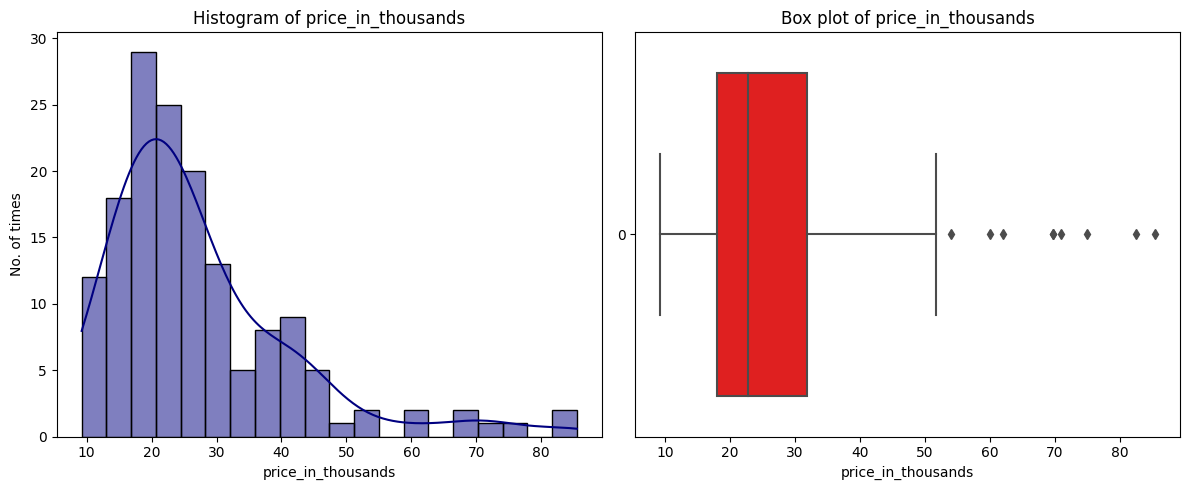

In [22]:
#histogram plot of data
var = "price_in_thousands" #change the variable name to see for different column 
fig,axs = plt.subplots(1,2,figsize=(12,5))
sns.histplot(dataset_transformation[var],bins=20,edgecolor='black',color='navy',kde=True,ax=axs[0])
axs[0].set_xlabel(var)
axs[0].set_ylabel("No. of times")
axs[0].set_title("Histogram of "+var)

#box plot
sns.boxplot(data=dataset_transformation[var],color='red',orient='h',ax=axs[1])
axs[1].set_xlabel(var)
axs[1].set_title("Box plot of "+var)

plt.tight_layout()
plt.show()

In [23]:
def remove_outliers(data,col):
    temp_data = data.copy()
    for var in col:
        # Calculating quartiles and IQR
        q1, q3 = temp_data[var].quantile([0.25, 0.75])
        iqr = q3 - q1

        # Calculating lower and upper bounds
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Counting number of outliers
        outliers = (temp_data[var] < lower_bound) | (temp_data[var] > upper_bound)
        num_outliers = outliers.sum()

        print(f'Number of outliers of {var}:', num_outliers)

        temp_data[var] = np.where(temp_data[var] > upper_bound, upper_bound, temp_data[var])
        temp_data[var] = np.where(temp_data[var] < lower_bound, lower_bound, temp_data[var])
        
    return temp_data

In [24]:
dataset_outlier_modified = dataset_transformation.copy()
dataset_outlier_modified = remove_outliers(dataset_outlier_modified,numeric_cols) #removal of outlier from numeric data type using IQR method


Number of outliers of sales_in_thousands: 5
Number of outliers of year_resale_value: 15
Number of outliers of engine_size: 2
Number of outliers of horsepower: 2
Number of outliers of wheelbase: 4
Number of outliers of width: 0
Number of outliers of length: 3
Number of outliers of curb_weight: 4
Number of outliers of fuel_capacity: 5
Number of outliers of fuel_efficiency: 1
Number of outliers of power_perf_factor: 2
Number of outliers of price_in_thousands: 9


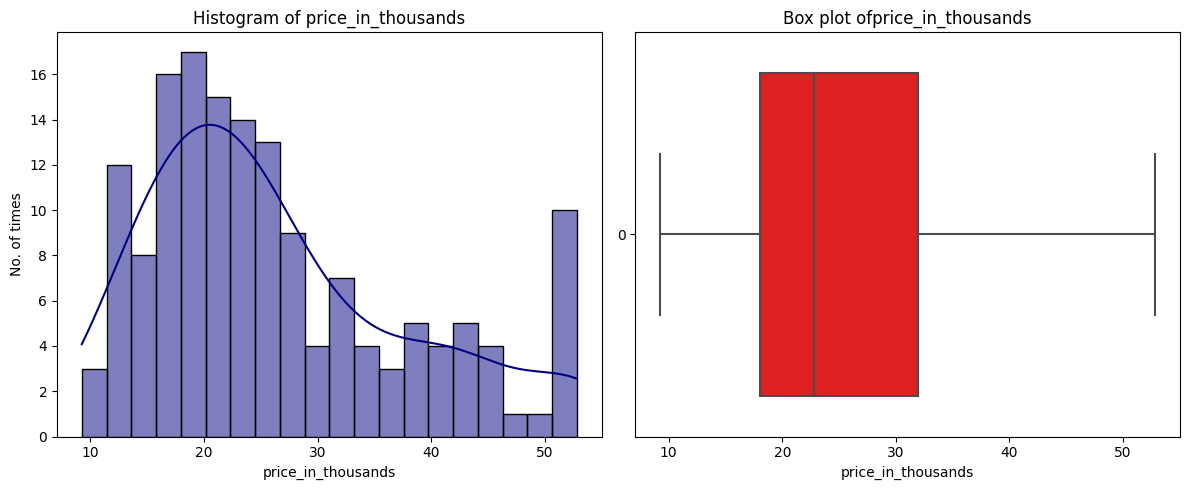

In [25]:
#histogram plot of data
var = "price_in_thousands" #change the variable name to see for different column 
fig,axs = plt.subplots(1,2,figsize=(12,5)) 
sns.histplot(dataset_outlier_modified[var],bins=20,edgecolor='black',color='navy',kde=True,ax=axs[0])
axs[0].set_xlabel(var)
axs[0].set_ylabel("No. of times")
axs[0].set_title("Histogram of "+var)

#box plot
sns.boxplot(data=dataset_outlier_modified[var],color='red',orient='h',ax=axs[1])
axs[1].set_xlabel(var)
axs[1].set_title("Box plot of"+var)

plt.tight_layout()
plt.show()

**Correlation** 

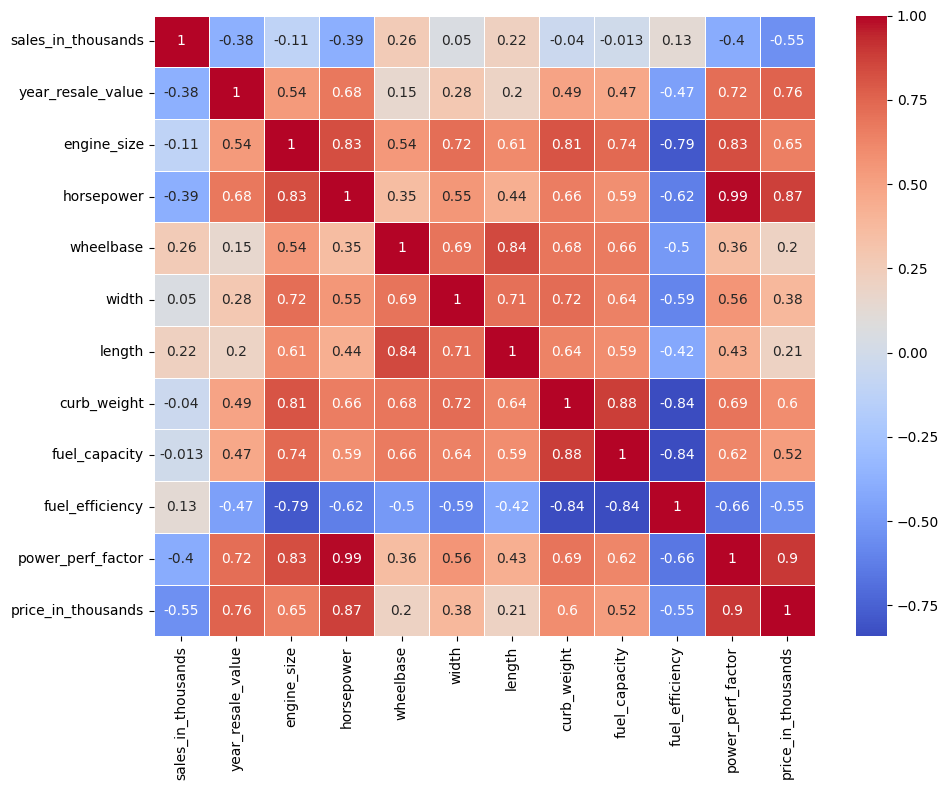

In [26]:
#plotting correalation matrix
correlation_matrix = dataset_outlier_modified[numeric_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix,annot=True,linewidths=.5,cmap='coolwarm')
plt.tight_layout()
plt.show()

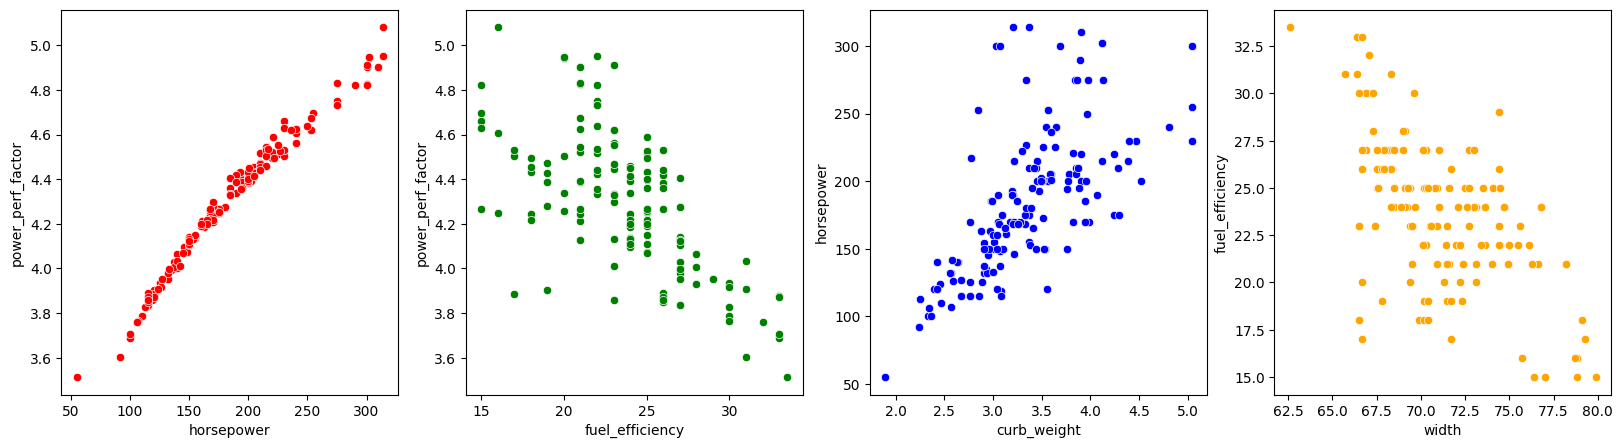

In [27]:
# setting figure size
plt.figure(figsize=(20,5))

# creating subplots for each scatter plot
plt.subplot(1, 4, 1)
sns.scatterplot(x='horsepower',y='power_perf_factor',data = dataset_outlier_modified,color='red')

plt.subplot(1, 4, 2)
sns.scatterplot(x='fuel_efficiency',y='power_perf_factor',data = dataset_outlier_modified,color='green')

plt.subplot(1, 4, 3)
sns.scatterplot(x='curb_weight',y='horsepower',data = dataset_outlier_modified,color='blue')

plt.subplot(1, 4, 4)
sns.scatterplot(x='width',y='fuel_efficiency',data = dataset_outlier_modified,color='orange')

# displaying the plots
plt.show()

In [28]:
def calculate_vif(data):
    vif = pd.DataFrame()
    vif['features'] = data.columns
    vif['vif_value'] = [variance_inflation_factor(data.values,i) for i in range(len(data.columns))]
    return vif

In [29]:
features = dataset_outlier_modified.iloc[:,:-1]
features = features.select_dtypes(include=['float64'])
calculate_vif(features)

,features,vif_value
0,sales_in_thousands,13.691379
1,year_resale_value,137.120503
2,engine_size,90.216510
3,horsepower,195.340713
4,wheelbase,1142.382160
5,width,1193.864813
6,length,917.407228
7,curb_weight,225.000727
8,fuel_capacity,1179.078545
9,fuel_efficiency,180.226047


In [30]:
dataset_outlier_modified[numeric_cols].corr()

,sales_in_thousands,year_resale_value,engine_size,horsepower,wheelbase,width,length,curb_weight,fuel_capacity,fuel_efficiency,power_perf_factor,price_in_thousands
sales_in_thousands,1.000000,-0.377573,-0.108400,-0.386113,0.264903,0.050427,0.222771,-0.039621,-0.012541,0.126455,-0.399074,-0.547088
year_resale_value,-0.377573,1.000000,0.537088,0.680369,0.150965,0.280723,0.196870,0.490475,0.474369,-0.467259,0.715248,0.757641
engine_size,-0.108400,0.537088,1.000000,0.827753,0.543569,0.716106,0.607163,0.809912,0.736944,-0.787490,0.830681,0.647788
horsepower,-0.386113,0.680369,0.827753,1.000000,0.352972,0.553833,0.435104,0.656093,0.588951,-0.622829,0.987138,0.872385
wheelbase,0.264903,0.150965,0.543569,0.352972,1.000000,0.691262,0.844949,0.683997,0.663089,-0.499786,0.358428,0.204640
width,0.050427,0.280723,0.716106,0.553833,0.691262,1.000000,0.710969,0.722395,0.642962,-0.594842,0.557096,0.383191
length,0.222771,0.196870,0.607163,0.435104,0.844949,0.710969,1.000000,0.638775,0.593881,-0.423498,0.431534,0.208375
curb_weight,-0.039621,0.490475,0.809912,0.656093,0.683997,0.722395,0.638775,1.000000,0.884475,-0.836799,0.692072,0.595262
fuel_capacity,-0.012541,0.474369,0.736944,0.588951,0.663089,0.642962,0.593881,0.884475,1.000000,-0.842200,0.621321,0.519428
fuel_efficiency,0.126455,-0.467259,-0.787490,-0.622829,-0.499786,-0.594842,-0.423498,-0.836799,-0.842200,1.000000,-0.657310,-0.548451


In [31]:
#create new dataframe to store feature selection
dataset_feature_selection = dataset_outlier_modified.copy()

#selection of feature on the basis of variance inflation factor
dataset_feature_selection = dataset_feature_selection.drop(['year_resale_value','power_perf_factor','curb_weight','fuel_capacity','length','wheelbase','engine_size'],axis=1)
features = dataset_feature_selection.iloc[:,:-1]
features = features.select_dtypes(include=['float64'])
calculate_vif(features)

,features,vif_value
0,sales_in_thousands,10.587685
1,horsepower,30.063960
2,width,132.943330
3,fuel_efficiency,39.297848


In [32]:
#dropping latest launch 
dataset_feature_selection = dataset_feature_selection.drop(['latest_launch','model'],axis=1)  

In [33]:
dataset_feature_selection.head()

,manufacturer,sales_in_thousands,vehicle_type,horsepower,width,fuel_efficiency,price_in_thousands
0,Acura,2.828437,Passenger,140.0,67.3,28.0,21.50
1,Acura,3.673360,Passenger,225.0,70.3,25.0,28.40
3,Acura,2.150366,Passenger,210.0,71.4,22.0,42.00
4,Audi,3.015388,Passenger,150.0,68.2,27.0,23.99
5,Audi,2.932792,Passenger,200.0,76.1,22.0,33.95


In [34]:
dataset_feature_selection['manufacturer'].unique()

array(['Acura', 'Audi', 'BMW', 'Buick', 'Cadillac', 'Chevrolet',
       'Chrysler', 'Dodge', 'Ford', 'Honda', 'Hyundai', 'Infiniti',
       'Jaguar', 'Jeep', 'Lexus', 'Lincoln', 'Mitsubishi', 'Mercury',
       'Mercedes-B', 'Nissan', 'Oldsmobile', 'Plymouth', 'Pontiac',
       'Porsche', 'Saab', 'Saturn', 'Subaru', 'Toyota', 'Volkswagen',
       'Volvo'], dtype=object)

In [72]:
dataset_feature_selection['vehicle_type'].unique()

array(['Passenger', 'Car'], dtype=object)

**Encoding**

In [35]:
dataset_encoding = dataset_feature_selection.copy()

In [36]:
# dataset_encoding['vehicle_type'] = dataset_encoding['vehicle_type'] .replace({'Passenger': 0, 'Car': 1})
# dataset_encoding.head()
# dataset_encoding['vehicle_type'].value_counts()


In [148]:
dataset_encoding = pd.get_dummies(dataset_encoding)
dataset_encoding.head(10)

,sales_in_thousands,horsepower,width,fuel_efficiency,price_in_thousands,manufacturer_Acura,manufacturer_Audi,manufacturer_BMW,manufacturer_Buick,manufacturer_Cadillac,...,manufacturer_Pontiac,manufacturer_Porsche,manufacturer_Saab,manufacturer_Saturn,manufacturer_Subaru,manufacturer_Toyota,manufacturer_Volkswagen,manufacturer_Volvo,vehicle_type_Car,vehicle_type_Passenger
0,2.828437,140.0,67.3,28.0,21.5000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,3.673360,225.0,70.3,25.0,28.4000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2.150366,210.0,71.4,22.0,42.0000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3.015388,150.0,68.2,27.0,23.9900,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,2.932792,200.0,76.1,22.0,33.9500,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0.322083,310.0,74.0,21.0,52.8425,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,2.983002,170.0,68.4,26.0,26.9900,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
8,2.222567,193.0,68.5,24.0,33.4000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
9,2.863743,193.0,70.9,25.0,38.9000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
10,4.517005,175.0,72.7,25.0,21.9750,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [149]:
# dataset_encoding.info()

In [150]:
# dataset_encoding.columns
# dataset_encoding.shape

**Target and Input variable**


In [151]:
# Split the dataset into training and test sets
X = dataset_encoding.drop('price_in_thousands', axis=1)  # Features
Y = dataset_encoding['price_in_thousands']  # Target variable



In [152]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

In [153]:
scaling = StandardScaler()
scaling.fit(x_train.iloc[:,:4])
x_train.iloc[:,:4] = scaling.transform(x_train.iloc[:,:4])
x_test.iloc[:,:4] = scaling.transform(x_test.iloc[:,:4])

# Model 

In [154]:
#fit the model for training set
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [155]:
#predict the values for the training dataset
y_hat = model.predict(x_train)

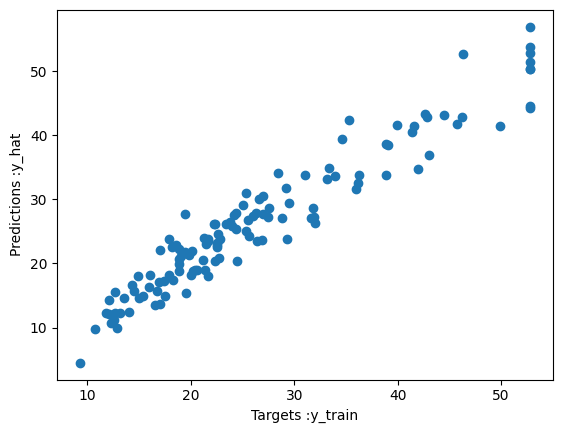

In [156]:
plt.scatter(y_train,y_hat)
plt.xlabel("Targets :y_train")
plt.ylabel("Predictions :y_hat")
plt.show()


Text(0.5, 1.0, 'Residual PDF')

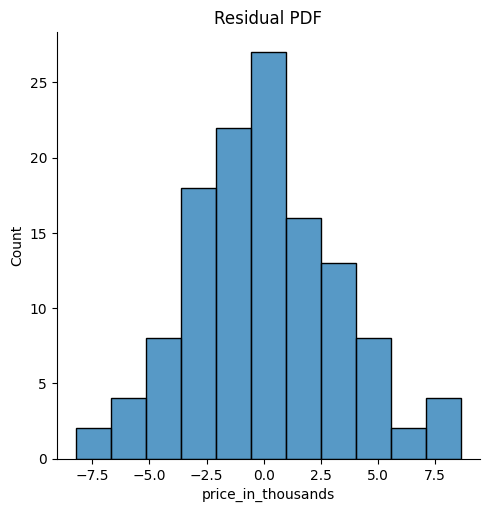

In [157]:
#draw the residual plot
sns.displot(y_train - y_hat)
plt.title("Residual PDF")

In [158]:
model.score(x_train, y_train)

0.9195954314093544

**Test model**

In [159]:
#predict the values for the training dataset
y_hat_test = model.predict(x_test)


In [160]:
df_pf = pd.DataFrame(y_hat_test,columns=['Predicted Sale Price'])


In [233]:
y_test = y_test.reset_index(drop=True)
df_pf['Actual Sale Price'] = y_test
df_pf.head()

,Predicted Sale Price,Actual Sale Price
0,24.507812,25.450
1,34.945312,51.728
2,32.667969,28.340
3,23.863281,22.245
4,26.054688,25.310


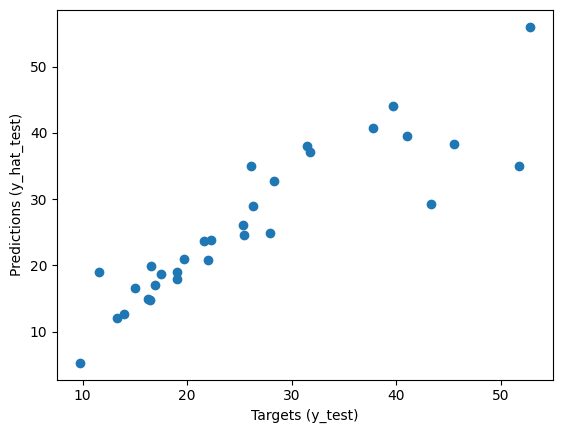

In [162]:
plt.scatter(y_test,y_hat_test)
plt.xlabel("Targets (y_test)")
plt.ylabel("Predictions (y_hat_test)")
plt.show()

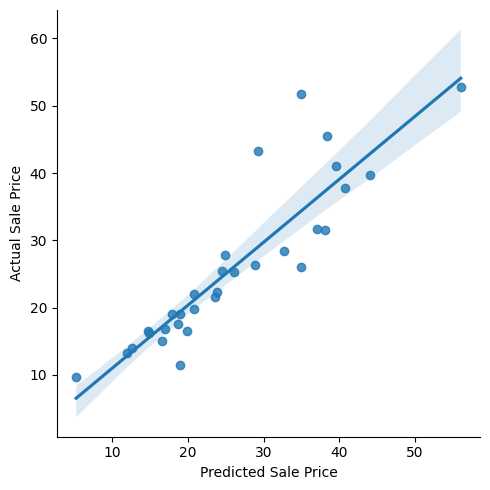

In [163]:
sns.lmplot(data=df_pf,x='Predicted Sale Price', y='Actual Sale Price')
plt.show()

In [231]:
r2_value = r2_score(y_test,y_hat_test)
print('r2 score: ', r2_value)

r2 score:  0.7939012728788738


In [232]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test,y_hat_test)
print('Mean Absolute Error:', mae)

mse = mean_squared_error(y_test,y_hat_test)
print('Mean Squared Error:', mse)

Mean Absolute Error: 3.657391129032258
Mean Squared Error: 27.97549164005796


In [164]:
#dump pickle file
import pickle
pickle_out = open("car_price.pkl","wb")
pickle.dump(model,pickle_out)
pickle_out.close()

# Dump the scaler object to a file
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaling, f)